# 4.2 Elo prediction and the single Elimination Bracket

The long-term rank correlation value of the "Elo on the Single Elimination Bracket" in figure 4.1 is slightly below what is observed in other formats tested. In this notebook, I investigate the case starting with a simple clearly defined model and extending to larger simulation. It provides a first formal identification of what matchmaking overfitting can be. This is fascinating as the Elo and the single elimination bracket are two of the most famous, used and studied algorithms in competition, yet what is next presented is never mentioned nor considered.

## 4.2.1 Formal approach

The problem, when doing simulation with a small number of players, is that the distribution of levels has a massive impact on the ranking behavior. The importance of a population model becomes key. You can not simply draw values from a distribution - the sample size is too small to be representative.

### Probability Model
I decided to fix a smooth probability table. The model maintains a strict transitive relationship between the players. If P(A wins against B) > 0.5 and P(B wins against C) > 0.5 then P(A wins against C) > 0.5.

In [1]:
def matrixC1():
    table = []
    inc = 0.05
    for i in range(8):
        table.append([round(0.5-i*inc+j*inc,2) for j in range(8)])
    return table

c1 = matrixC1()
c1

[[0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85],
 [0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8],
 [0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75],
 [0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7],
 [0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65],
 [0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6],
 [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55],
 [0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]]

### Seedings in a Single Elimination Bracket

For n=8 players, there are $\frac{n!}{2^{n-1}}=\frac{8!}{2^7} = 315$ different initial seedings. One may think that with 8 players, you have $8!$ different way to sort them. But a single elimination tree is a binary tree, with a lot of structural symmetries, and the model does not make a difference between a confrontation "$p_1$ versus $p_2$" and "$p_2$ versus $p_1$".

The reprSEB iterator produces class representatives such that the highest seed of a subtree is always the left most element i.e

For a ~ b, defined below, reprSEB produces a but not b.<br>
a:= (0, 7, 3, 4, 1, 6, 2, 5)<br>
b:= (4, 3, 7, 0, 6, 1, 2, 5)<br>
Both seedings a and b results in the same Bracket:

```mermaid
graph BT
    %% Round 3 - final
    F["Final 0/3/4/7 vs 1/2/5/6 ......"]

    %% Round 2 - semi final
    SF1["SF1 Seed 0/7 vs 3/4   ......"] --> F
    SF2["SF2 Seed 1/6 vs 2/5   ......"] --> F
    
    %% Round 1 - quarter final
    QF1["QF1 Seed 0 vs Seed 7 ......"] --> SF1
    QF2["QF1 Seed 3 vs Seed 4 ......"] --> SF1
    QF3["QF1 Seed 1 vs Seed 6 ......"] --> SF2
    QF4["QF1 Seed 2 vs Seed 5 ......"] --> SF2
```

In [2]:
from utils.sebiter import reprSEB
from utils import treeprob as tp
import math

labels = list(range(8))
seedings = list(reprSEB(labels))
assert len(seedings) == len(set(seedings)) == math.factorial(len(labels)) // 2**(len(labels)-1) == 315

### Metrics

In [3]:
def compute_bracket(seedings, matrix):
    results = []
    for seeding in seedings:
        bracket = tp.treeprob(seeding, matrix)
        results.append({
            'seeding': seeding,
            'ExpectedScore': [tp.expected_score(seed, bracket) for seed in labels],
            'WinProb': [tp.score_prob(seed, 3, bracket) for seed in labels] # win the final, i.e. win the 3rd round
        })
    return results

results = compute_bracket(seedings, c1)

In [4]:
def groundtruth(labels, matrix):
    """Natural Expected Score"""
    return [sum(matrix[seed]) for seed in labels]

GROUNDTRUTH = groundtruth(labels, c1)
GROUNDTRUTH

[5.4, 5.0, 4.6, 4.2, 3.8, 3.4, 3.0, 2.6]

In [5]:
from utils.metrics import argmin, argmax
from scipy import stats

def analysis(results: dict, labels: list[int], gt: list[float]):
    NB = len(labels)
    fav = [0 for i in range(NB)]
    scoring = [0 for i in range(NB)]
    mins = [1 for i in range(NB)]
    maxs = [0 for i in range(NB)]
    worst_es = (None, 1.0)
    worst_wp = (None, 1.0)
    
    for result in results:
        for i in labels:
            mins[i] = min(mins[i], result['WinProb'][i])
            maxs[i] = max(maxs[i], result['WinProb'][i])
            if argmax(result['WinProb']) == i:
                fav[i] += 1
            if argmax(result['ExpectedScore']) == i:
                scoring[i] += 1
            result['GTCOR_ES'] = stats.kendalltau(gt, result['ExpectedScore'])[0]
            result['GTCOR_WP'] = stats.kendalltau(gt, result['WinProb'])[0]
            if result['GTCOR_WP'] < worst_wp[1]:
                worst_wp = (result['seeding'], result['GTCOR_WP'])
            if result['GTCOR_ES'] < worst_es[1]:
                worst_es = (result['seeding'], result['GTCOR_ES'])
    return fav, scoring, mins, maxs, worst_es, worst_wp

In [6]:
fav, scoring, mins, maxs, worst_es, worst_wp = analysis(results, labels, GROUNDTRUTH)

print('worst seed regarding winner probabilities', worst_wp[0], worst_wp[1])
print('worst seed regarding expected score', worst_es[0], worst_es[1], '\n')

for i in labels:
    print(f'player {i} win prob:', f'min = {mins[i]:.4f},',
          f'max = {maxs[i]:.4f},',
          f'favorite in {fav[i]}',
          f', topscorer in {scoring[i]}')

worst seed regarding winner probabilities (0, 1, 2, 4, 3, 7, 5, 6) 0.7857142857142856
worst seed regarding expected score (0, 3, 1, 4, 2, 5, 6, 7) 0.2857142857142857 

player 0 win prob: min = 0.2560, max = 0.4014, favorite in 299 , topscorer in 205
player 1 win prob: min = 0.1798, max = 0.3096, favorite in 16 , topscorer in 68
player 2 win prob: min = 0.1235, max = 0.2390, favorite in 0 , topscorer in 32
player 3 win prob: min = 0.0851, max = 0.1806, favorite in 0 , topscorer in 9
player 4 win prob: min = 0.0570, max = 0.1344, favorite in 0 , topscorer in 1
player 5 win prob: min = 0.0364, max = 0.0915, favorite in 0 , topscorer in 0
player 6 win prob: min = 0.0218, max = 0.0607, favorite in 0 , topscorer in 0
player 7 win prob: min = 0.0118, max = 0.0354, favorite in 0 , topscorer in 0


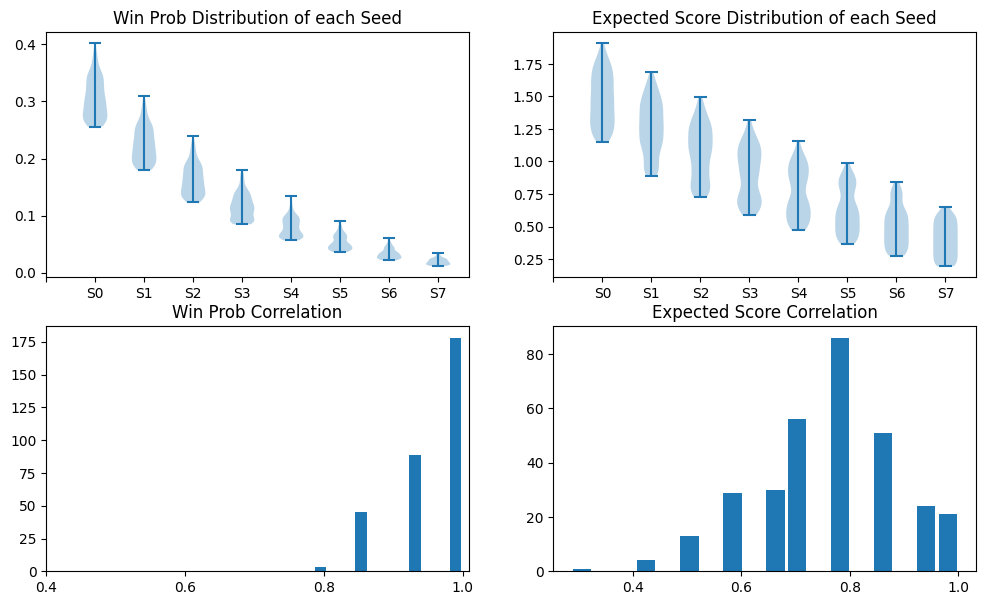

In [7]:
import matplotlib.pyplot as plt

NB = len(labels)

fig, axs = plt.subplots(2, 2, figsize=(12, 7))

win_dist = [[result['WinProb'][i] for result in results] for i in labels]
exp_dist = [[result['ExpectedScore'][i] for result in results] for i in labels]

axs[0][0].violinplot(win_dist)
axs[0][0].set_xticks(list(range(NB+1)), labels=[None]+[f'S{i}' for i in labels])
axs[0][0].set_title('Win Prob Distribution of each Seed')

axs[0][1].violinplot(exp_dist)
axs[0][1].set_xticks(list(range(NB+1)), labels=[None]+[f'S{i}' for i in labels])
axs[0][1].set_title('Expected Score Distribution of each Seed')

axs[1][0].hist(x=[result['GTCOR_WP'] for result in results], bins='auto', rwidth=0.85)
axs[1][0].set_xticks([0.4, 0.6, 0.8, 1.0])
axs[1][0].set_title('Win Prob Correlation')

axs[1][1].hist(x=[result['GTCOR_ES'] for result in results], bins='auto', rwidth=0.85)   
axs[1][1].set_xticks([0.4, 0.6, 0.8, 1.0])
axs[1][1].set_title('Expected Score Correlation')

plt.show()

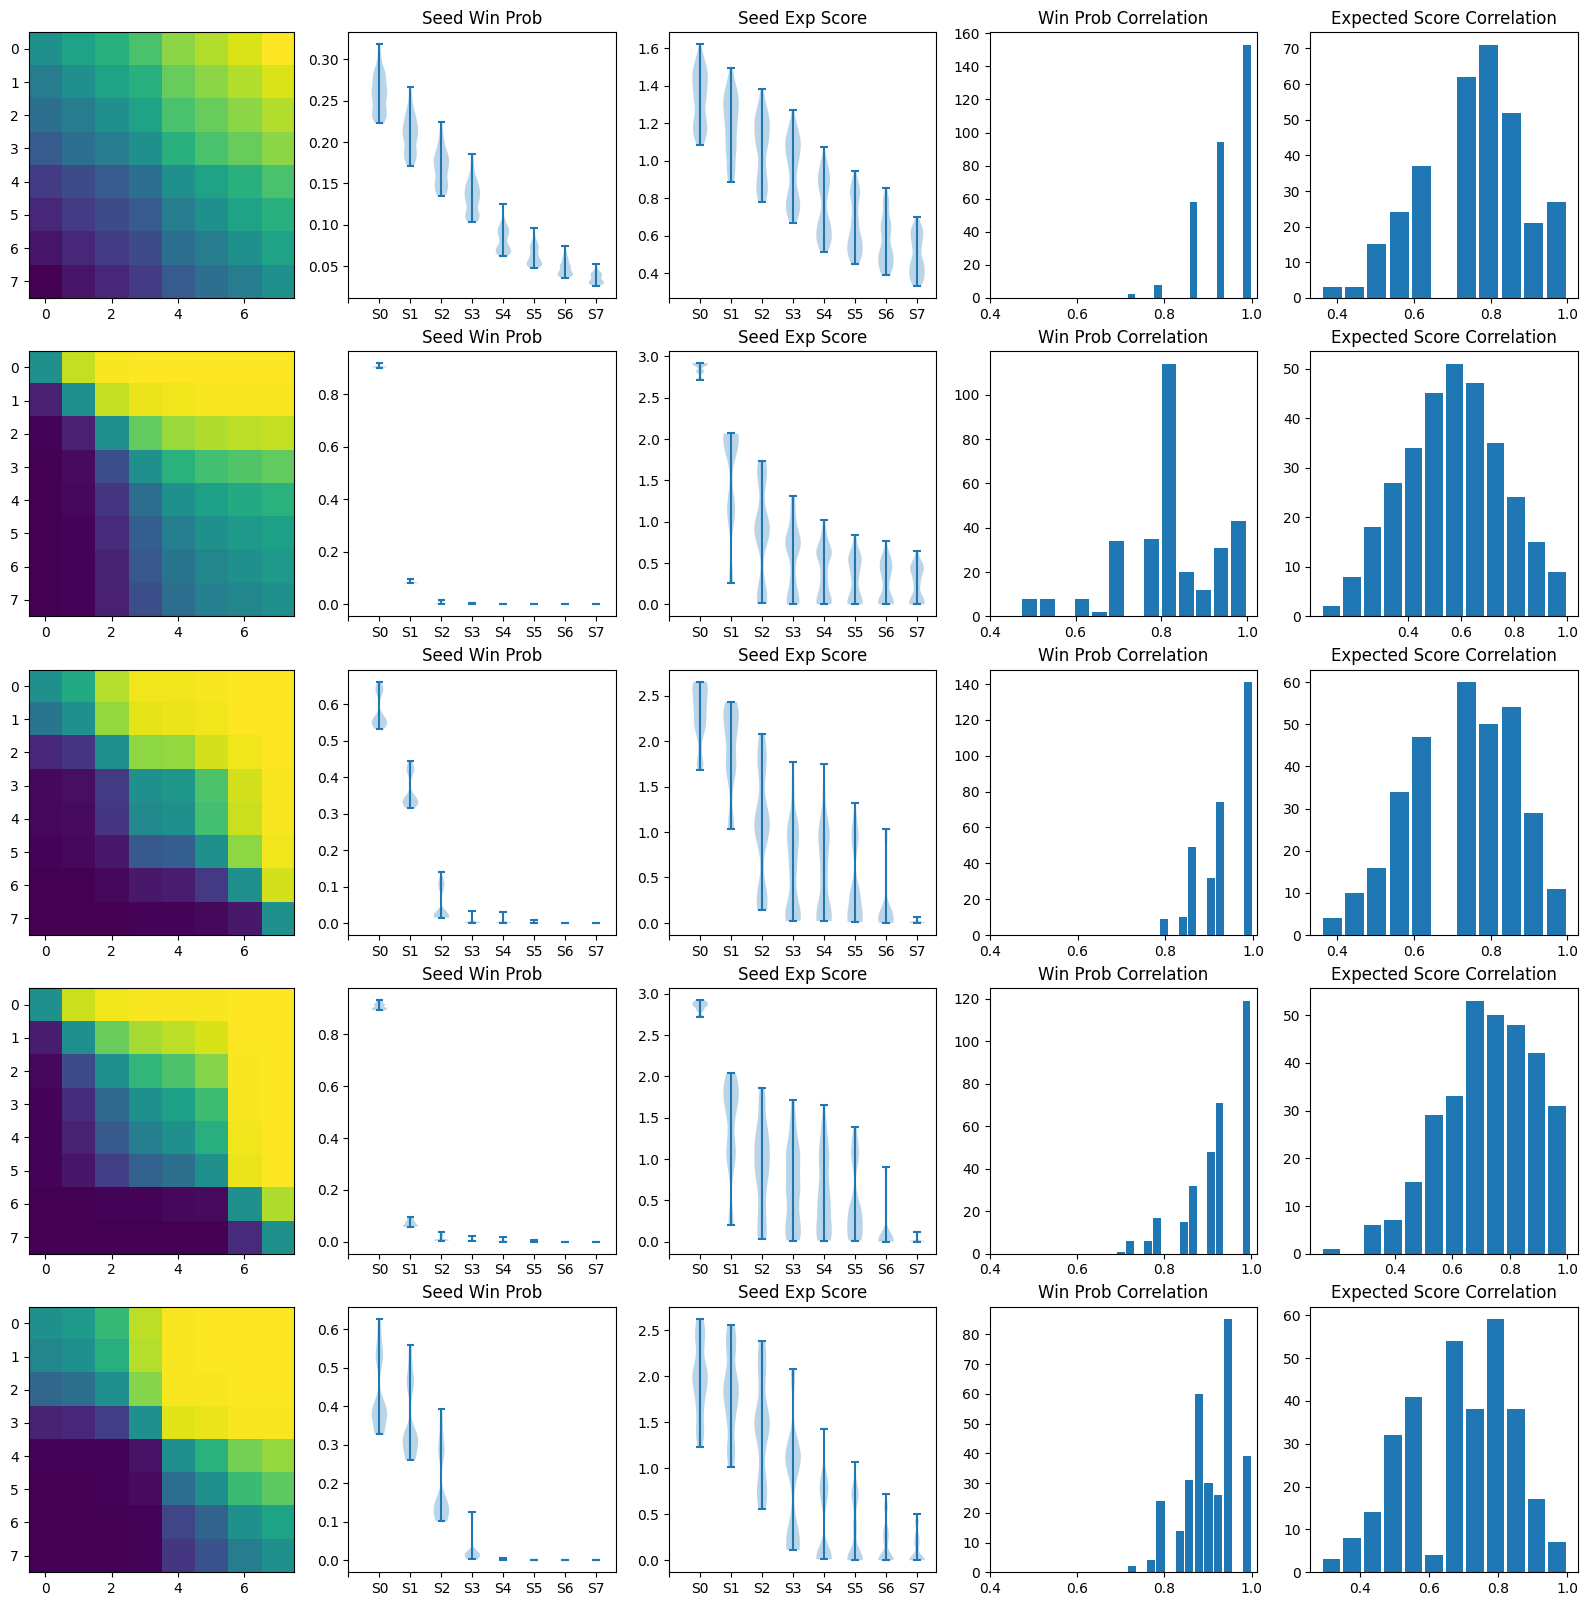

In [8]:
from rstt import BasicPlayer, Duel, BTRanking, LogSolver
from utils import visualisation as visul

def prob_matrix(gt: BTRanking) -> list[list[float]]:
    '''convert rstt model to probability matrix'''
    matrix = []
    for p1 in gt:
        line = []
        for p2 in gt:
            if p1 != p2:
                line.append(round(LogSolver().probabilities(Duel(p1, p2))[0], 2))
            else:
                line.append(0.5)
        matrix.append(line)
    return matrix

# 5 test model
models = [
    prob_matrix(BTRanking('linear', [BasicPlayer('Seed{i}', 1000+l) for i, l in zip(labels, [-100, -75, -50, -25, 25, 50, 75, 100])])),
    prob_matrix(BTRanking('elitist', [BasicPlayer('Seed{i}', 1000+l) for i, l in zip(labels, [0, 25, 50, 100, 200, 400, 800, 1200])])),
    prob_matrix(BTRanking('gauss1', BasicPlayer.create(nb=8))),
    prob_matrix(BTRanking('gauss2', BasicPlayer.create(nb=8))),
    prob_matrix(BTRanking('gauss3', BasicPlayer.create(nb=8))),
]

# run, analysis & plot
fig, axs = plt.subplots(len(models), 5, figsize=(20, 20))
for matrix, row in zip(models, axs):
    truth = groundtruth(labels, matrix)
    results = compute_bracket(seedings, matrix)
    fav, scoring, mins, maxs, worst_es, worst_wp = analysis(results, labels, truth)
    visul.visualize_bracket_analysis(results, labels, matrix, row)
plt.show()

In [9]:
# print a model summary
model = 2# len(models)
matrix = models[model]
truth = groundtruth(labels, matrix)
results = compute_bracket(seedings, matrix)
fav, scoring, mins, maxs, worst_es, worst_wp = analysis(results, labels, truth)
visul.summary(fav, scoring, mins, maxs, worst_es, worst_wp, labels)

worst seed regarding winner probabilities (0, 4, 5, 7, 1, 6, 2, 3) 0.7857142857142856
worst seed regarding expected score (0, 2, 3, 5, 1, 4, 6, 7) 0.3571428571428571 

player 0 win prob: min = 0.5325, max = 0.6626, favorite in 315 , topscorer in 262
player 1 win prob: min = 0.3162, max = 0.4445, favorite in 0 , topscorer in 31
player 2 win prob: min = 0.0148, max = 0.1385, favorite in 0 , topscorer in 20
player 3 win prob: min = 0.0002, max = 0.0337, favorite in 0 , topscorer in 1
player 4 win prob: min = 0.0001, max = 0.0296, favorite in 0 , topscorer in 1
player 5 win prob: min = 0.0000, max = 0.0071, favorite in 0 , topscorer in 0
player 6 win prob: min = 0.0000, max = 0.0002, favorite in 0 , topscorer in 0
player 7 win prob: min = 0.0000, max = 0.0000, favorite in 0 , topscorer in 0


## 4.2.3 Protocol

Considering the Bradly-Terry model, we generate n=64 players with a constant level, the game mode is "one-versus-one", and the solver is the LogSolver. The scheduler is a Single Elimination Bracket tournament seeded by an Elo ranking. We perform the \textit{RSSC} loop with $depth = 1000$. Between two tournament editions $event_{i}, event_{i+1}$, the ranking is updated with the games played in $event_i$, and then used to seed $event_{i+1}$. This produces a dataset of $depth * (n-1) = 1000 * 63 =63'000$ ordered games.

For evaluation, we consider 4 moments $m=200,400,600,800$. For each of these moments we generate a training set with games played up to the tournament $event_{m}$, and a test set with all games played after it. We then train and evaluate an Elo ranking. 

As a remark, the evaluation could have been done during the simulation process. We can ask the ranking to make predictions on the games before the updates. The choice to split the simulation from the evaluation was made to have a more realistic empirical approach. I can upload my dataset on the internet, someone else can download it and evaluate his ranking on it. The data production is strictly separated from the system evaluation (here the Elo ranking).

In [10]:
import random
from rstt import SingleEliminationBracket as SEB
from rstt import BasicElo

# Players
population = BasicPlayer.create(nb=64, level_dist=random.gauss, level_params={'mu':1500, 'sigma':500})
population = BasicPlayer.create(nb=256, level_dist=random.gauss, level_params={'mu':1500, 'sigma':500})

# Solver
solver = LogSolver(base=10, lc=400)

# Test Ranking
elo = BasicElo('Elo', players=population)

# Sheduler
scheduler = SEB

# Interaction
depth = 1000

# Ground-Truth
gt = BTRanking('Consensus', population)
gt.plot()

# moments
splits = [200, 400, 600, 800]

----------- Consensus -----------
   0.         Mary Wayland       2983
   1.            Mark Koch       2903
   2.         Debra Brooks       2691
   3.        Richard Smith       2662
   4.           Craig Vera       2633
   5.          James Parks       2604
   6.       Morgan Moseley       2567
   7.      Timothy Lindsey       2557
   8.         Cathy Machin       2531
   9.       Steven Wheeler       2521
  10.       Lorraine Clark       2514
  11.       Jasmine Tarpey       2501
  12.     Felicia Vargason       2471
  13.           Keira Hurt       2442
  14.         Kathy Quiroz       2433
  15.            Ken Irion       2414
  16.         Sonya Taylor       2411
  17.         David Hawker       2372
  18.       Melissa Ozment       2341
  19.        Bart Robinson       2331
  20.          Tina Burger       2308
  21.        Roberta Clark       2285
  22.      Victoria Harris       2273
  23.        David Lechner       2227
  24.          Venus Clark       2224
  25.        Dol

In [11]:
from dataclasses import dataclass
from rstt import Ranking
from rstt.stypes import Event, SPlayer, SMatch
from utils.rssc import rssc

@dataclass
class SebEloData:
    ratings: dict[SPlayer, float]
    games: list[SMatch]
    truth: dict[SPlayer, float]

def datasets(ranking: Ranking, event: Event, ref: Ranking) -> SebEloData:
    return SebEloData(ratings={p: ranking.rating(p) for p in ref},
                      games=event.games(),
                      truth={p: ref.rating(p) for p in ref})

## 4.2.3 Results

In [12]:
from collections import Counter
import itertools

Encounters = Counter[tuple[int, int], int]

def load_data(results: list[SebEloData]) -> list[SMatch]:
    return [game for result in results for game in result.games]

def load_testset(start: int, end: int, results: list[SebEloData]) -> list[SMatch]:
    return [game for result in results for game in result.games]

def trained_elo(m: int, results: list[SebEloData]) -> BasicElo:
    elo = BasicElo(f'Elo after {m} tournament')
    for p, r in results[m-1].ratings.items():
        elo.set_rating(p, r)
    return elo

def seen_data(games: list[Duel], ref: Ranking) -> Encounters:
    return Counter([(ref[duel.player1()], ref[duel.player2()]) for duel in games])

def unseen_data(domain: Encounters, ref: Ranking) -> Encounters:
    nb = len(ref)
    return Counter([(i, j) for i in range(nb) for j in range(nb) if (i, j) not in domain and i != j])

def domain(mm_domain: Encounters, ref: Ranking) -> list[list[int]]:
    nb = len(ref)
    return [[mm_domain[(i, j)] for i in range(nb)] for j in range(nb)]


In [13]:
from rstt import WIN
from rstt.stypes import Solver


def elo_predict(elo: BasicElo, duel: Duel) -> float:
    r1 = elo.datamodel.get(duel.player1())
    r2 = elo.datamodel.get(duel.player2())
    return elo.backend.expectedScore(r1, r2)

def true_prob(duel: Duel, solver: Solver) -> float:
    return solver.probabilities(duel)[solver.scores.index(WIN)]

def observedProb(outcomes: list[float]) -> float:
    return sum(outcomes)/len(outcomes)


In [14]:
from functools import partial

results = rssc(name='SEBELO', seed=elo, cup=scheduler, solver=solver, depth=depth, metric=partial(datasets, ref=gt))
print('simulation done')

simulation done


In [15]:
import numpy as np

@dataclass
class AbstentData:
    domain: Encounters
    predictions: list[float]
    truths: list[float]
    bias: np.array

@dataclass
class ExpVsObs:
    ranking: Ranking
    data: list[SMatch]
    training_domain: list[list[int]]
    test_domain: list[list[int]]
    predictions: list[float]
    outcomes: list[float]
    truths: list[float]
    synthetic: AbstentData

def load_data(results: list[SebEloData]) -> list[SMatch]:
    return [game for result in results for game in result.games]

def biased_predictions(data: list[Duel], ref: Ranking, solver: Solver):
    nb = len(ref)
    bias = np.full((nb, nb), -1, dtype=float)
    for duel in data:
        p1, p2 = duel.player1(), duel.player2()
        i, j = ref[p1], ref[p2]
        bias[i, j] = abs(elo_predict(ref, duel) - true_prob(duel, solver))
    return bias

def eval_elo(elo: BasicElo, train: list[Duel], test:list[Duel], solver: Solver) -> ExpVsObs:
    sd = seen_data(train, elo)
    ud = unseen_data(sd, elo)
    synthetic = [Duel(elo[i], elo[j]) for (i, j) in ud.keys()]
    
    nodata = AbstentData(domain=domain(ud, elo),
                         predictions=[elo_predict(elo, duel) for duel in synthetic],
                         truths=[true_prob(duel, solver) for duel in synthetic],
                         bias = biased_predictions(synthetic, elo, solver)
                        )
    return ExpVsObs(ranking=elo,
                    data=test,
                    training_domain = domain(seen_data(train, elo), elo),
                    test_domain = domain(seen_data(test, elo), elo),
                    predictions = [elo_predict(elo, duel) for duel in test],
                    outcomes = [1 if duel.winner() == duel.player1() else 0 for duel in test],
                    truths = [true_prob(duel, solver) for duel in test],
                    synthetic = nodata
                   )


analysis: list[ExpVsObs] = []
for split in splits:
    telo = trained_elo(split, results)
    print('elo trained')

    training_set = load_data(results[:split])
    test_set = load_data(results[split:])
    data = load_testset(start=split, end=depth, results=results)
    print('test set loaded')

    analysis.append(eval_elo(telo, training_set, test_set, solver))

elo trained
test set loaded
elo trained
test set loaded
elo trained
test set loaded
elo trained
test set loaded


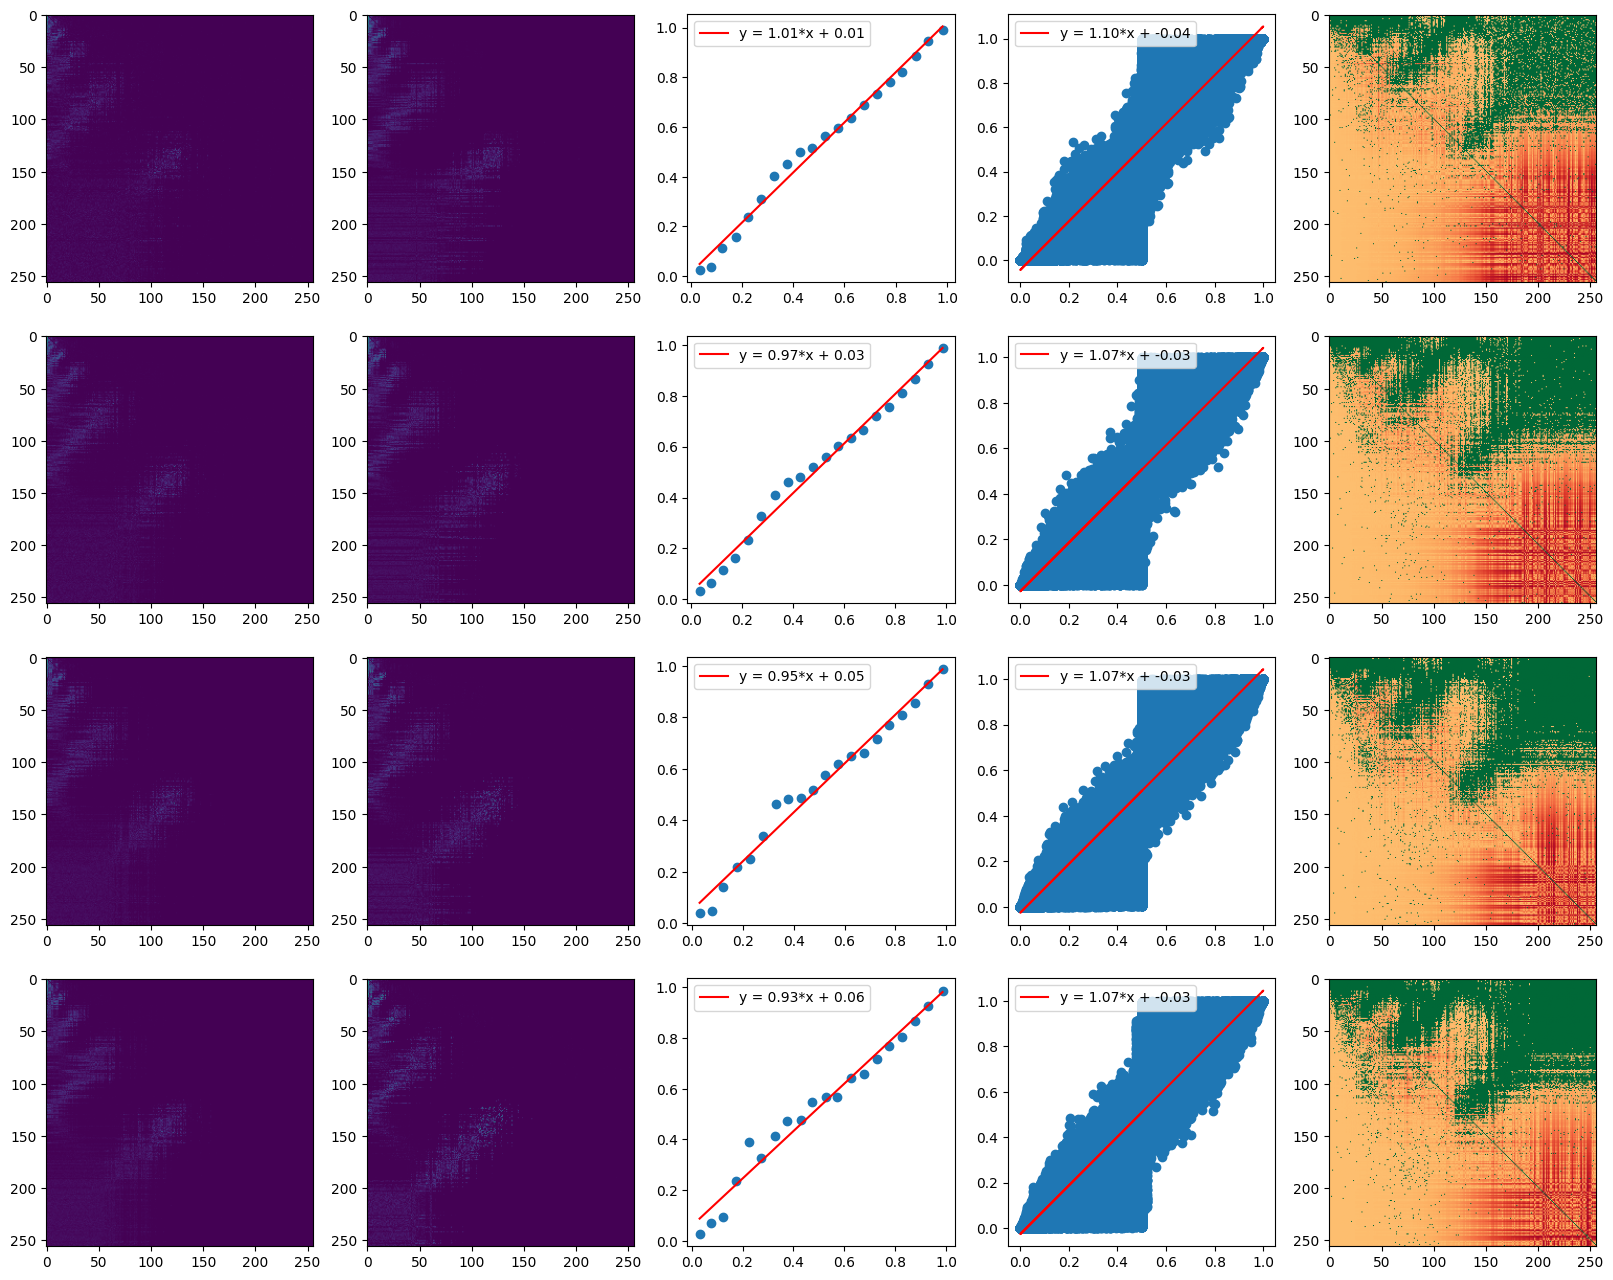

In [16]:
def expected_vs_observed(predictions: list[float], outcomes: list[float], bins: int): 
    expected, observed = [], []
    inc = 100//bins
    for i in range(0, bins):
        lower = (i * inc)/100
        upper = ((i+1) * inc)/100
        
        indices = [i for i, val in enumerate(predictions) if lower <= val < upper]
        scores = [outcomes[i] for i in indices]
        preds = [predictions[i] for i in indices]
        if preds:
            expected.append(sum(preds) / len(preds))
            observed.append(sum(scores)/ len(scores))
    return expected, observed


fig, axs = plt.subplots(4,5, figsize=(20, 16))
for res, ax in zip(analysis, axs):
    ax[0].imshow(res.training_domain)
    
    ax[1].imshow(res.test_domain)

    exp, obs = expected_vs_observed(res.predictions, res.outcomes , bins=20)
    axis = np.array(exp)
    lr = stats.linregress(exp, obs)
    ax[2].plot(exp, obs, 'o')
    ax[2].plot(axis, lr.intercept + lr.slope*axis, 'r', label=f'y = {lr.slope:.2f}*x + {lr.intercept:.2f}')
    ax[2].legend()
    
    exp, obs = res.synthetic.predictions, res.synthetic.truths
    axis = np.array(exp)
    lr = stats.linregress(exp, obs)
    ax[3].plot(exp, obs, 'o')
    ax[3].plot(axis, lr.intercept + lr.slope*axis, 'r', label=f'y = {lr.slope:.2f}*x + {lr.intercept:.2f}')
    ax[3].legend()

    ax[4].imshow(res.synthetic.bias, cmap='RdYlGn_r', vmin=-1, vmax=0.5)
    
plt.show()

In [17]:
from rstt import RoundRobin

sebelo_rank_diff = [gt[p]-elo[p] for p in gt]

rr = RoundRobin('fix elo', elo, solver)
rr.registration(elo.players())
rr.run()

elo.update(games=rr.games())
rrelo_rank_diff = [gt[p]-elo[p] for p in gt]

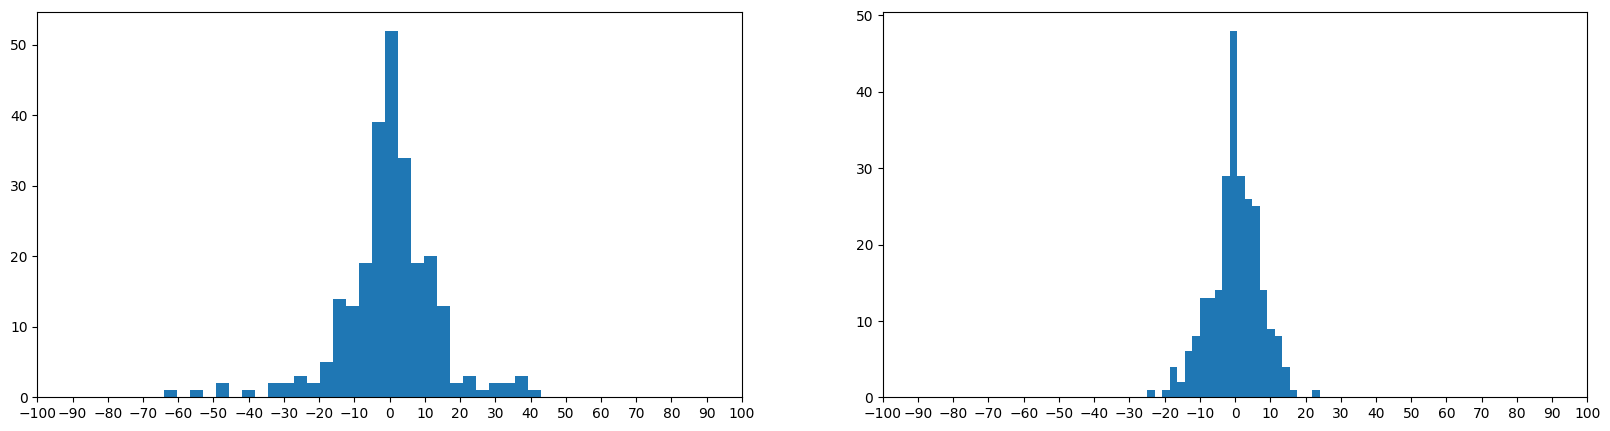

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

axs[0].hist(sebelo_rank_diff, bins='auto')
axs[0].set_xticks(list(range(-100, 101, 10)))
axs[1].hist(rrelo_rank_diff, bins='auto')
axs[1].set_xticks(list(range(-100, 101, 10)))
plt.show()

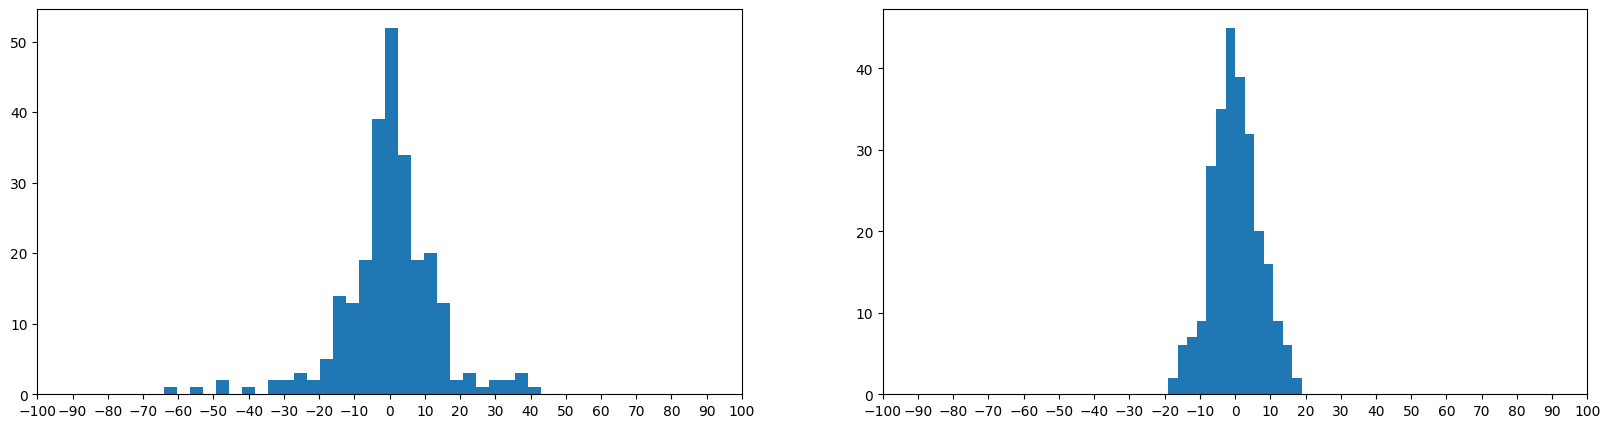

In [19]:
rr = RoundRobin('fix elo', elo, solver)
rr.registration(elo.players())
rr.run()

elo.update(games=rr.games())
rrelo_rank_diff = [gt[p]-elo[p] for p in gt]

fig, axs = plt.subplots(1, 2, figsize=(20, 5))

axs[0].hist(sebelo_rank_diff, bins='auto')
axs[0].set_xticks(list(range(-100, 101, 10)))
axs[1].hist(rrelo_rank_diff, bins='auto')
axs[1].set_xticks(list(range(-100, 101, 10)))
plt.show()